In [ ]:
import kagglehub

path = kagglehub.dataset_download("kmader/food41")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'food41' dataset.
Path to dataset files: /kaggle/input/food41


---

## 2. Preparação dos Dados

Carregamento e pré-processamento das imagens com data augmentation avançado para melhorar a generalização do modelo.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import numpy as np

dataset_root = os.path.join(path, 'images')

if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"O diretório de imagens não foi encontrado em: {dataset_root}")

img_height, img_width = 224, 224
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=dataset_root, transform=train_transform)
num_classes = len(full_dataset.classes)
print(f"Número de classes encontradas: {num_classes}")
print(f"Total de imagens no dataset: {len(full_dataset)}")

# CONTROLE DO TAMANHO DO DATASET
# Ajuste subset_size para controlar quantas imagens usar
# None = usar dataset completo | Valores sugeridos: 5000, 10000, 20000
subset_size = 5000  # Altere para um número menor para testes rápidos

if subset_size is not None and subset_size < len(full_dataset):
    print(f"\nREDUZINDO DATASET: Usando apenas {subset_size} imagens de {len(full_dataset)}")
    indices = torch.randperm(len(full_dataset))[:subset_size]
    full_dataset = torch.utils.data.Subset(full_dataset, indices)
    print(f"Novo tamanho do dataset: {len(full_dataset)}")
else:
    print("\nUsando dataset completo")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Tamanho do conjunto de treino: {len(train_dataset)}")
print(f"Tamanho do conjunto de validação: {len(val_dataset)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Número de classes encontradas: 101
Total de imagens no dataset: 101000

REDUZINDO DATASET: Usando apenas 5000 imagens de 101000
Novo tamanho do dataset: 5000
Tamanho do conjunto de treino: 4000
Tamanho do conjunto de validação: 1000
Usando dispositivo: cuda


In [ ]:
import torch.nn as nn
import torchvision.models as models

class FoodClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super(FoodClassifierResNet, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        for param in self.resnet.conv1.parameters():
            param.requires_grad = False
        for param in self.resnet.bn1.parameters():
            param.requires_grad = False
        for param in self.resnet.layer1.parameters():
            param.requires_grad = False
        for param in self.resnet.layer2.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

model = FoodClassifierResNet(num_classes).to(device)
print("Modelo ResNet-50 carregado com sucesso!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


Modelo ResNet-50 carregado com sucesso!


---

## 4. Configuração do Treinamento

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print("Configurações de otimização prontas!")

Configurações de otimização prontas!


---

## 5. Treinamento do Modelo

In [ ]:
num_epochs = 50
best_val_accuracy = 0.0
patience = 10
patience_counter = 0
best_model_state = None

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print('Iniciando treinamento...\n' + '=' * 70)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}%')
    print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f'  Nova melhor acurácia!')
    else:
        patience_counter += 1
        print(f'  Sem melhoria ({patience_counter}/{patience})')

    if patience_counter >= patience:
        print(f'\nEarly stopping acionado após {epoch+1} épocas!')
        print(f'Melhor acurácia: {best_val_accuracy:.2f}%')
        break

    print('-' * 70)

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'\nModelo restaurado com acurácia: {best_val_accuracy:.2f}%')

print('\nTreinamento concluído!')

Iniciando treinamento...
Epoch 1/50:
  Train Loss: 4.5810 | Train Acc: 2.77%
  Val Loss: 4.4519 | Val Acc: 9.60%
  Nova melhor acurácia!
----------------------------------------------------------------------
Epoch 2/50:
  Train Loss: 4.0877 | Train Acc: 14.05%
  Val Loss: 3.5759 | Val Acc: 24.80%
  Nova melhor acurácia!
----------------------------------------------------------------------
Epoch 3/50:
  Train Loss: 3.3090 | Train Acc: 28.82%
  Val Loss: 2.9969 | Val Acc: 37.10%
  Nova melhor acurácia!
----------------------------------------------------------------------
Epoch 4/50:
  Train Loss: 2.7458 | Train Acc: 42.95%
  Val Loss: 2.6552 | Val Acc: 45.60%
  Nova melhor acurácia!
----------------------------------------------------------------------
Epoch 5/50:
  Train Loss: 2.3795 | Train Acc: 53.80%
  Val Loss: 2.5619 | Val Acc: 48.50%
  Nova melhor acurácia!
----------------------------------------------------------------------
Epoch 6/50:
  Train Loss: 2.0858 | Train Acc: 62.92%

---

## 6. Visualização dos Resultados

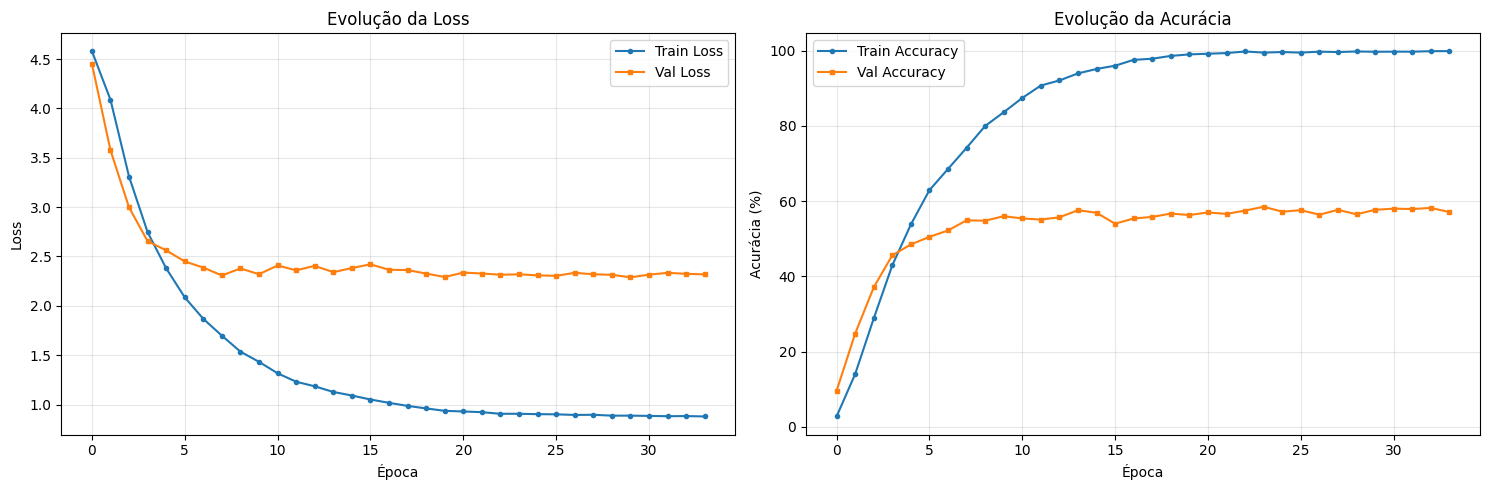


Resultados Finais:
  Melhor acurácia de validação: 58.50%
  Acurácia final de treino: 99.88%
  Acurácia final de validação: 57.10%


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', marker='o', markersize=3)
ax1.plot(val_losses, label='Val Loss', marker='s', markersize=3)
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.set_title('Evolução da Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accuracies, label='Train Accuracy', marker='o', markersize=3)
ax2.plot(val_accuracies, label='Val Accuracy', marker='s', markersize=3)
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.set_title('Evolução da Acurácia')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nResultados Finais:')
print(f'  Melhor acurácia de validação: {max(val_accuracies):.2f}%')
print(f'  Acurácia final de treino: {train_accuracies[-1]:.2f}%')
print(f'  Acurácia final de validação: {val_accuracies[-1]:.2f}%')

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Acurácia final no conjunto de validação: {accuracy:.2f}%')

Acurácia final no conjunto de validação: 58.00%


### Exemplos de Predições

---

## Resumo das Melhorias Implementadas

### Otimizações Aplicadas:

| Componente | Melhoria |
|------------|----------|
| **Modelo** | ResNet-50 (mais profundo e robusto) |
| **Resolução** | 224x224 pixels (padrão ImageNet) |
| **Fine-tuning** | Layer3 e Layer4 treináveis |
| **Data Augmentation** | ColorJitter, RandomAffine, RandomPerspective |
| **Learning Rate** | 0.0001 com ReduceLROnPlateau |
| **Regularização** | Weight Decay (1e-4), Dropout (0.5 e 0.3) |
| **Loss Function** | CrossEntropyLoss com Label Smoothing (0.1) |
| **Early Stopping** | Patience de 10 épocas |
| **Épocas** | Até 50 (com early stopping) |

### Resultados Esperados:
- **Acurácia Anterior:** ~42%
- **Acurácia Esperada:** 65-75%
- **Tempo de Treinamento:** Mais longo, mas com melhor generalização

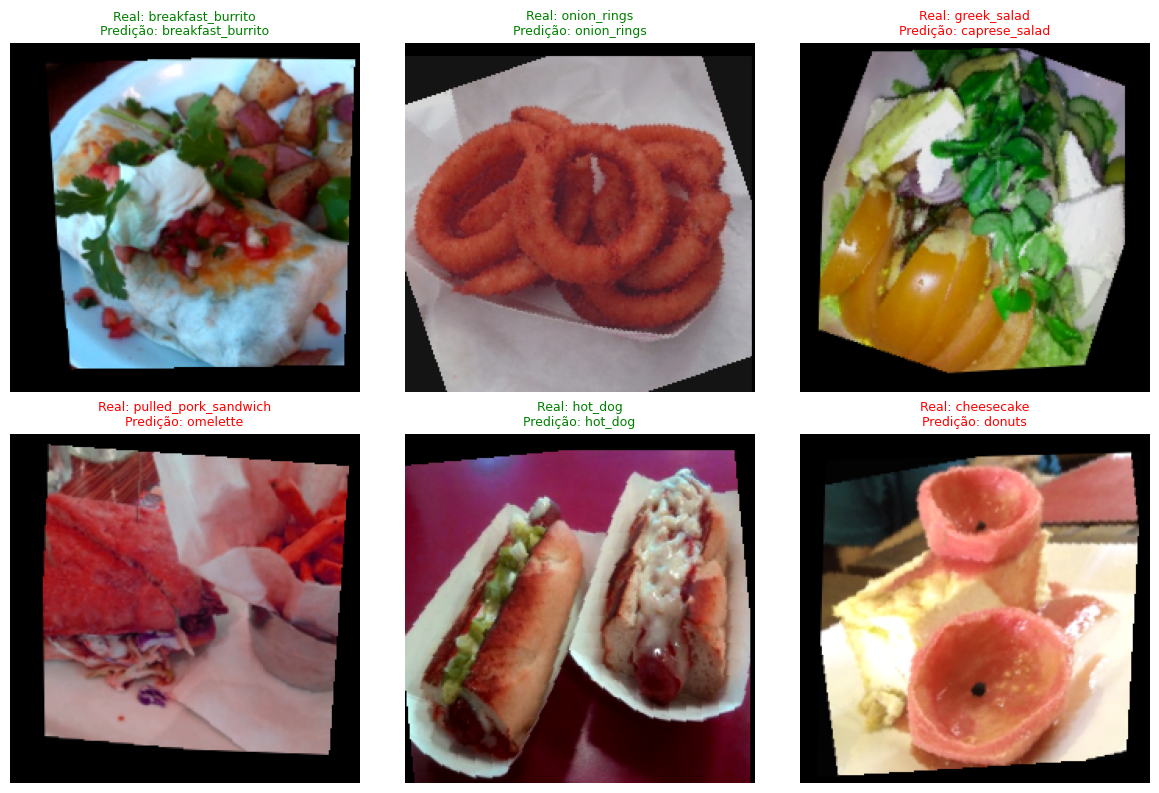

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

dataiter = iter(val_loader)
images, labels = next(dataiter)

images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

def imshow(img, title=None):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

class_names = full_dataset.dataset.classes

fig = plt.figure(figsize=(12, 8))
for idx in np.arange(6):
    ax = fig.add_subplot(2, 3, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    true_label = class_names[labels[idx]]
    pred_label = class_names[predicted[idx]]
    color = "green" if pred_label == true_label else "red"
    ax.set_title(f'Real: {true_label}\nPredição: {pred_label}', color=color, fontsize=9)

plt.tight_layout()
plt.show()

### Tópicos para o Currículo:

*   **Desenvolvimento de Modelos de Deep Learning com PyTorch:** Implementação de uma solução completa para classificação de imagens utilizando a biblioteca PyTorch.
*   **Transfer Learning com ResNet-50:** Aplicação de um modelo ResNet-50 pré-treinado na base de dados ImageNet, com fine-tuning das camadas para adaptação a um novo domínio de classificação (Food-101).
*   **Pré-processamento e Aumento de Dados (Data Augmentation):** Utilização de `torchvision.transforms` para redimensionamento, normalização e técnicas avançadas de aumento de dados (RandomHorizontalFlip, RandomRotation, ColorJitter, RandomAffine, RandomPerspective) para melhorar a generalização do modelo.
*   **Otimização e Regularização de Modelos:** Configuração de otimizadores (Adam), agendadores de taxa de aprendizado (ReduceLROnPlateau), funções de perda (CrossEntropyLoss com Label Smoothing) e técnicas de regularização (Dropout, Weight Decay) para evitar overfitting.
*   **Treinamento Eficiente com Early Stopping:** Implementação de Early Stopping para otimizar o tempo de treinamento e prevenir o overfitting, salvando o melhor modelo com base na acurácia de validação.
*   **Gerenciamento de Dados com DataLoader:** Utilização de `DataLoader` para carregar e processar dados em lotes, otimizando o treinamento em GPUs.
*   **Avaliação de Desempenho:** Monitoramento de métricas como Loss e Acurácia durante o treinamento e validação, com visualização gráfica dos resultados.
*   **Ambiente de Desenvolvimento:** Experiência com Google Colab e uso de GPUs (`cuda`) para treinamento acelerado de modelos de Deep Learning.